# Helmet and Motorcyclist Instance Segmentation using Mask R-CNN for traffic violations


Course: MTech (IS)

Project Owners: 

        Sudalaiandi Raja Sudalaimuthu
        Jayaram Revathi

# Installation guideline

#### Below are the steps to complete conda environment and folder structure setup

- Download and Setup Ananconda if you base conda does not exist


- open `Ananconda Prompt`


- 
` conda config --append channels conda-forge`


- Create a virtual conda environment `helmet`
 
` conda create -n helmet python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow-gpu=1.12.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras-gpu=2.1.6 pillow=5.4.1 notebook=5.7.4 pandas=0.24.2 h5py=2.8.0 cython  Pillow scikit-image  imgaug IPython[all] tqdm`


- Activate helmet conda environment
 
` conda activate helmet`


- Install pycocotools for cocoapi for datasets preparation
 
` pip install git+https://github.com/philferriere/cocoapi.git#egg=pycocotools^&subdirectory=PythonAPI`


- Clone from Helmet_Mask_RCNN project from the git repository
  
` git clone https://github.com/aivoyagers/Helmet_Mask_RCNN.git`


- Change current working directory to project base folder
  
` cd Helmet_Mask_RCNN`


- Setup Helmet_Mask_RCNN environment
  
` python setup.py install`


- Download datasets and offline trained model files from the google drive and copy to 'Helmt_Mask_RCNN' base folder 
  
` https://drive.google.com/drive/folders/1VHDlu76J1bScRBSy-4WsWI_mldf_Pf-b?usp=sharing`


- Open Jupyter Notebook for executing helmet_detect API
  
` jupyter notebook`


- Update 'COMMAND' to 'train' if fresh training on downloaded helmet 'train' & 'val' datasets. For test or inference, 'val' datasets required

- Execute helmet_detect.ipynb


In [32]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import helmet
from helmet import HelmetConfig
from helmet import train
from helmet import detect_and_color_splash

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

COMMAND = 'inference'   # Update to 'train' or 'inference'
HELMET_DIR = os.path.join(ROOT_DIR, "datasets/helmet")  # Update - Required for'train'
IMAGE_FILE = os.path.join(ROOT_DIR, "datasets/helmet/va/VID_20200315_181352_frame0.jpg") # Update - Required for 'inference'
VIDEO_FILE = None # either IMAGE_FILE or VIDEO_FILE required

# Update to 'coco' or 'last' - use the last generated weights or specify the weights file path
WEIGHTS = 'coco'  
# WEIGHTS = 'last'  
# WEIGHTS = os.path.join(ROOT_DIR, "mask_rcnn_helmet.h5") 

# Set to False if needs to be 'Motorcyclist_with_Helmet' or 'without_Helmet' instead
helmet.DEFAULT_LABEL_HELMET_SEPARATE = True 

helmet.NBR_OF_EPOCHS = 100

In [2]:
# Configurations

class InferenceConfig(HelmetConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

if COMMAND == "train":
    config = HelmetConfig()
    helmet.config = config
    config.display()
# else:
#     config = InferenceConfig()


# Create model
if COMMAND == "train":
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=MODEL_DIR)
    print ('Model loaded for training')
# else:
#     model = modellib.MaskRCNN(mode="inference", config=config,
#                               model_dir=MODEL_DIR)
#     print ('Model loaded for inference')


In [3]:
if COMMAND == 'train' :
    # Select weights file to load
    if WEIGHTS == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif WEIGHTS == "last":
        # Find last trained weights
        weights_path = model.find_last()
    elif WEIGHTS == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        weights_path = WEIGHTS
    print (f'Weights file selected for {WEIGHTS}')

    # Load weights
    print("Loading weights ", weights_path)
    if WEIGHTS == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)

    print(f'{weights_path} weights loaded')

In [4]:
# Train or evaluate
if COMMAND == "train":
    train(model, HELMET_DIR)


## Run Detection

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline 

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
# Set to inference configuration
config = InferenceConfig()
helmet.config = config

# Load model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)

# Find last trained weights
weights_path = model.find_last()

# Load weights
model.load_weights(weights_path, by_name=True)
print(f'{weights_path} weights loaded')

# Load validation dataset
dataset = helmet.HelmetDataset()
dataset.load_helmet(HELMET_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Re-starting from epoch 36
D:\Downloads\Helmet_Mask_RCNN\logs\helmet20200509T1224\mask_rcnn_helmet_0036.h5 weights loaded

************Dataset statistics for val************
Number of Images     43
class info           {'Motorcyclist': 1, 'Helmet': 2}
Nbr of Instances     {'Motorcyclist': 129, 'Helmet': 61}
Nbr of ignored Instances 13

Images: 43
Classes: ['BG', 'Motorcyclist', 'Helmet']


image ID: helmet.VID_20200315_181352_frame0.jpg (29) D:\Downloads\Helmet_Mask_RCNN\datasets/helmet\val\VID_20200315_181352_frame0.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (9,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (9, 4)                min:   41.00000  max:  809.00000  int32
gt_mask                  shape: (1024, 1024, 9)       min:    0.00000  max:    1.00000  bool


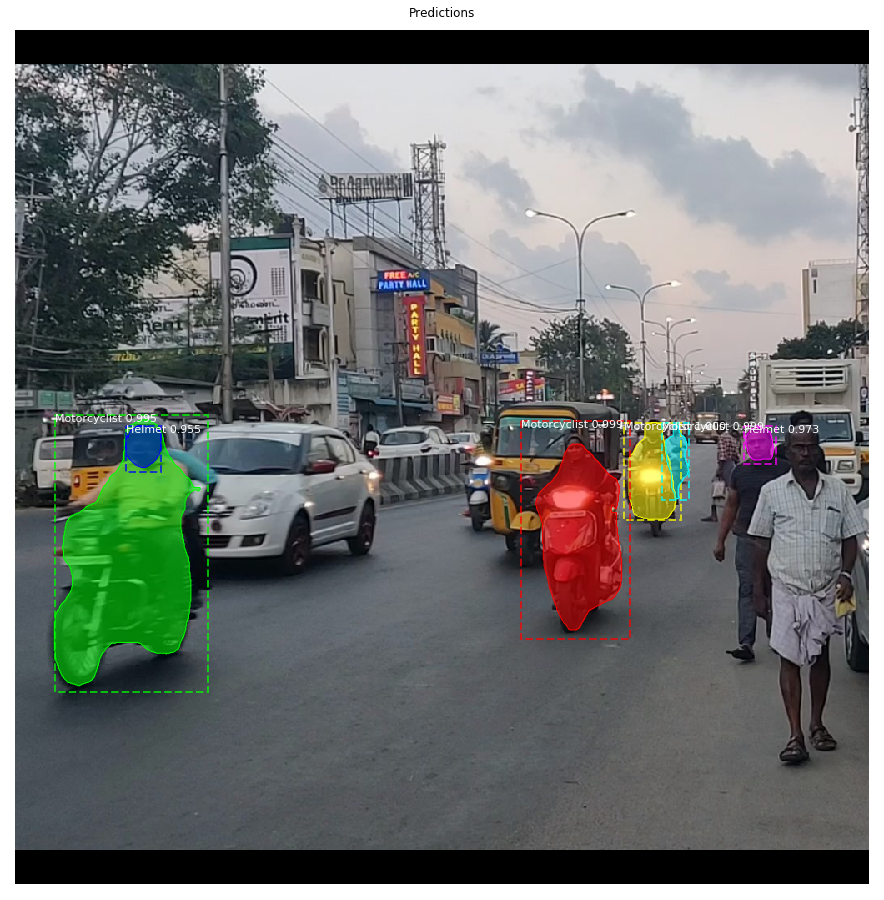

In [8]:
#image_id = random.choice(dataset.image_ids)
image_id = [i for i,_ in enumerate(dataset.image_info) if _['id'] == 'VID_20200315_181352_frame0.jpg'][0]
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Color Splash

This is for illustration. You can call `helmet.py` with the `splash` option to get better images without the black padding.

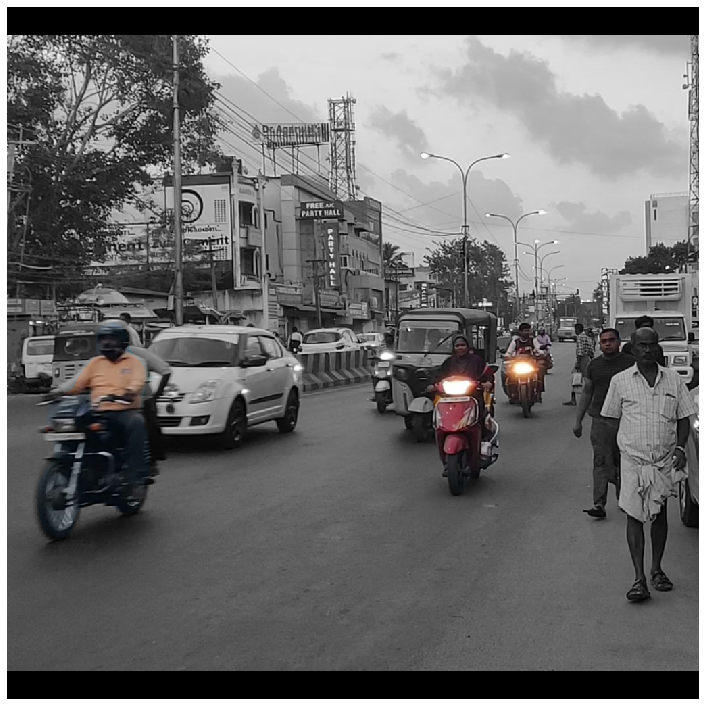

In [9]:
splash = helmet.color_splash(image, r['masks'])
display_images([splash], cols=1)

### Precision-Recall

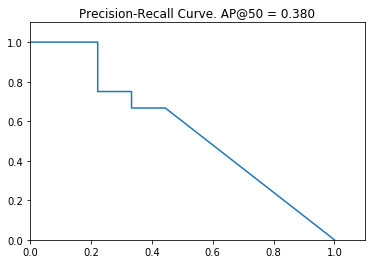

In [10]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

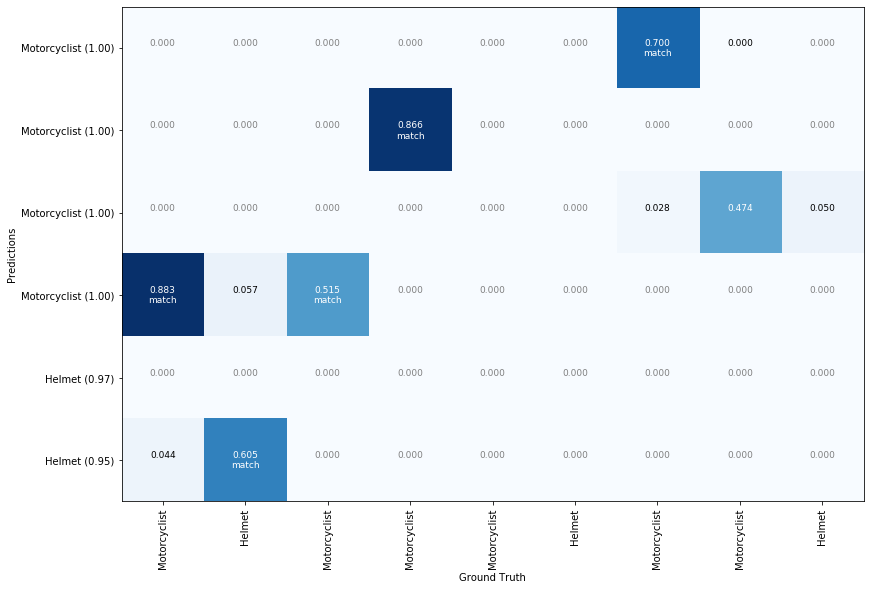

In [11]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [12]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.5816257920116186


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [13]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -8.66434  max:   13.03728  float64
positive_anchors         shape: (60, 4)               min:    0.00000  max:  853.01934  float64
negative_anchors         shape: (196, 4)              min:  -29.25483  max: 1173.01934  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (60, 4)               min:   40.99999  max:  809.00000  float32


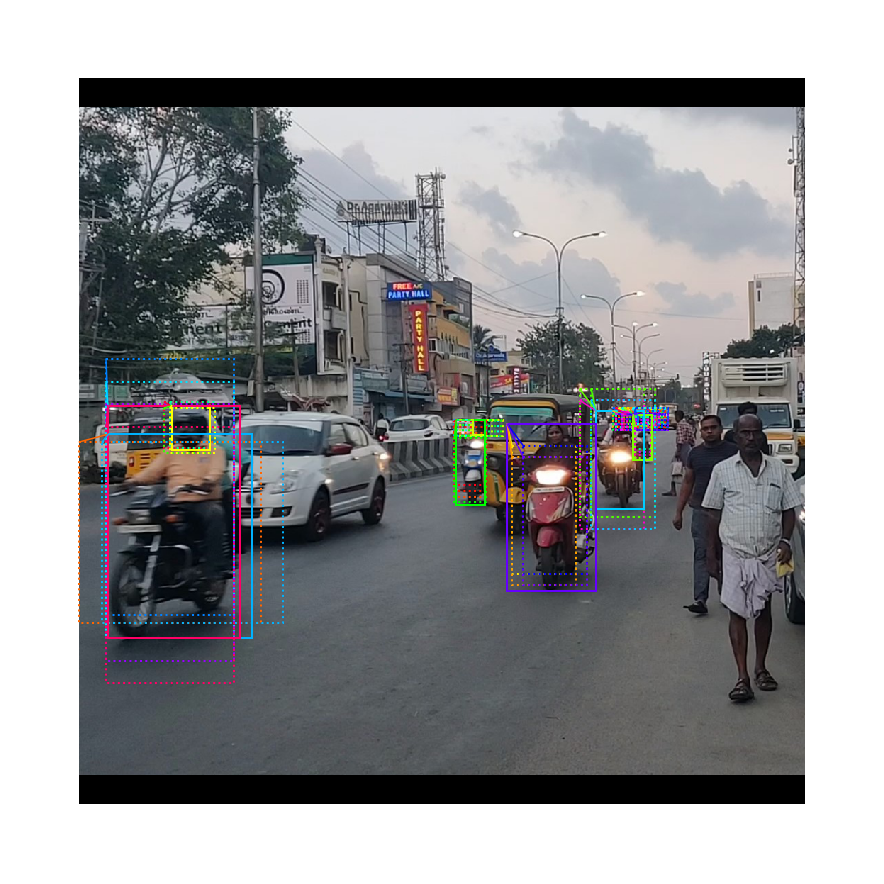

In [14]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [15]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 3, 4)       min:   -4.98283  max:    6.06663  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32


6 detections: ['Motorcyclist' 'Motorcyclist' 'Motorcyclist' 'Motorcyclist' 'Helmet'
 'Helmet']


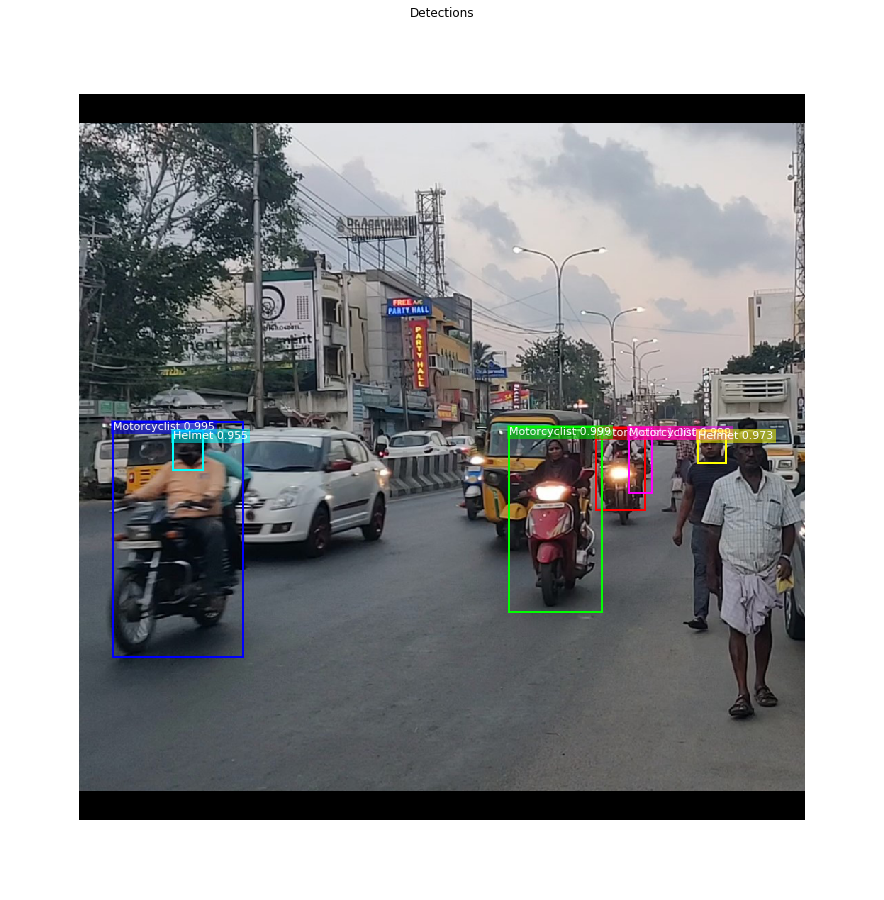

In [16]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [17]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
97 Positive ROIs
[('BG', 903), ('Helmet', 32), ('Motorcyclist', 65)]


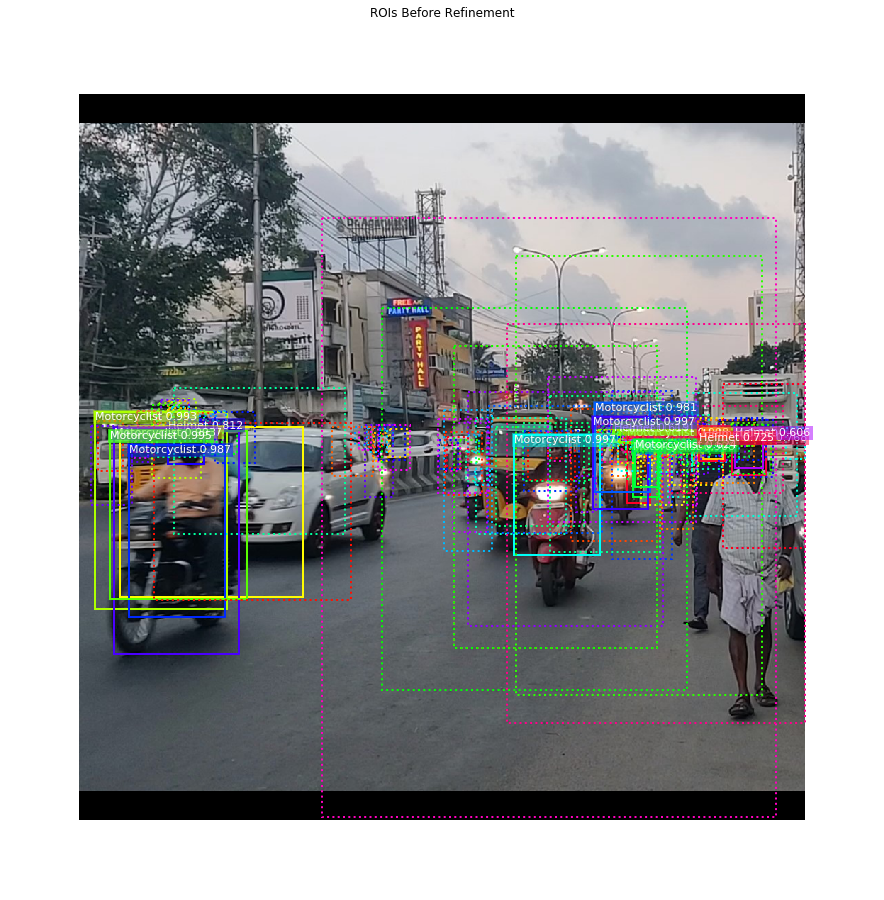

In [18]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -3.05172  max:    4.50430  float32
refined_proposals        shape: (1000, 4)             min:  -90.00000  max: 1138.00000  int32


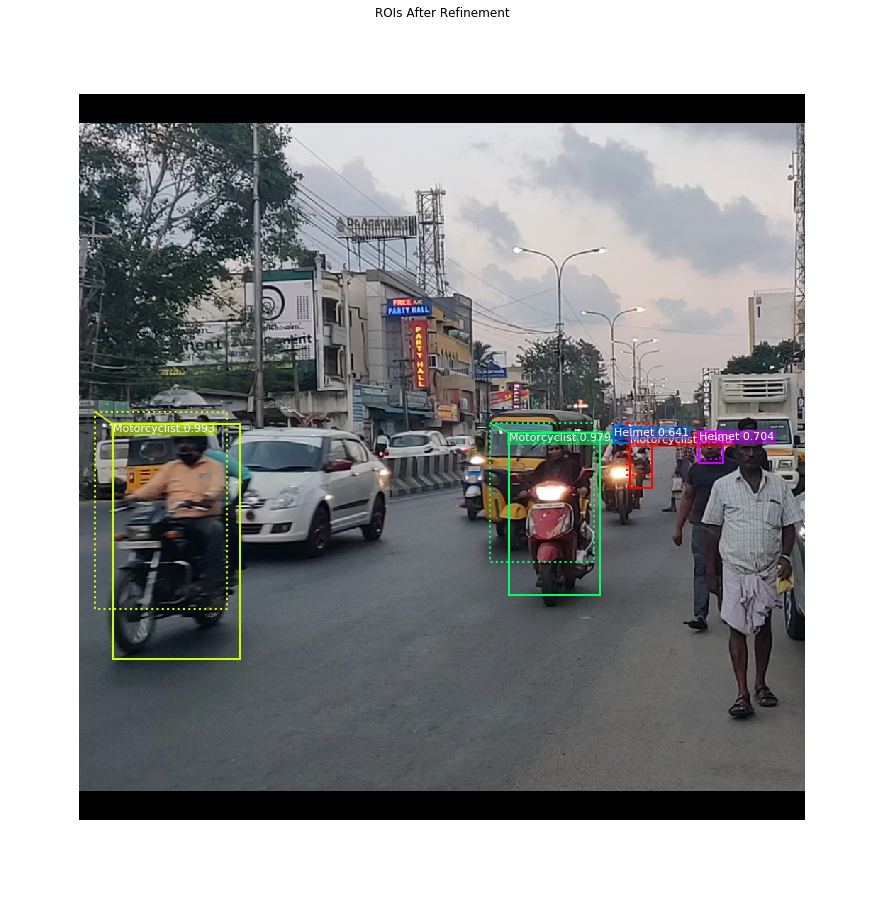

In [19]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [20]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 97 detections:
[  0   1   2   3   4   6   7  10  11  12  13  15  17  19  20  26  28  33
  35  37  38  39  40  42  44  46  56  59  63  69  91  92  93  97  99 100
 102 105 108 114 118 128 129 139 142 144 145 147 148 149 160 163 170 183
 184 188 191 192 194 197 198 211 216 227 240 245 265 266 269 276 279 290
 301 312 343 349 352 370 379 382 384 392 412 416 425 437 444 446 488 501
 510 524 668 670 675 706 915]


In [21]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 55:
[  0   1   2   3   4   6  10  12  13  15  19  37  38  39  40  42  44  46
  56  59  63  69  92  97 108 114 118 128 139 142 144 147 163 170 183 184
 191 211 216 240 276 290 312 343 349 352 370 384 392 416 425 437 444 670
 915]


#### Per-Class Non-Max Suppression

In [22]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

Motorcyclist          : [  0   1   2   3   4   6  10  12  13  19  37  38  39  40  44  46  56  59
  63  69  92  97 108 118 128 142 144 147 163 170 183 184 191 211 216 240
 290 312 343 349 352 370 384 392 416 425 437 444 670 915] -> [349   3  12  39]
Helmet                : [ 15  42 114 139 276] -> [139  42]

Kept after per-class NMS: 6
[  3  12  39  42 139 349]


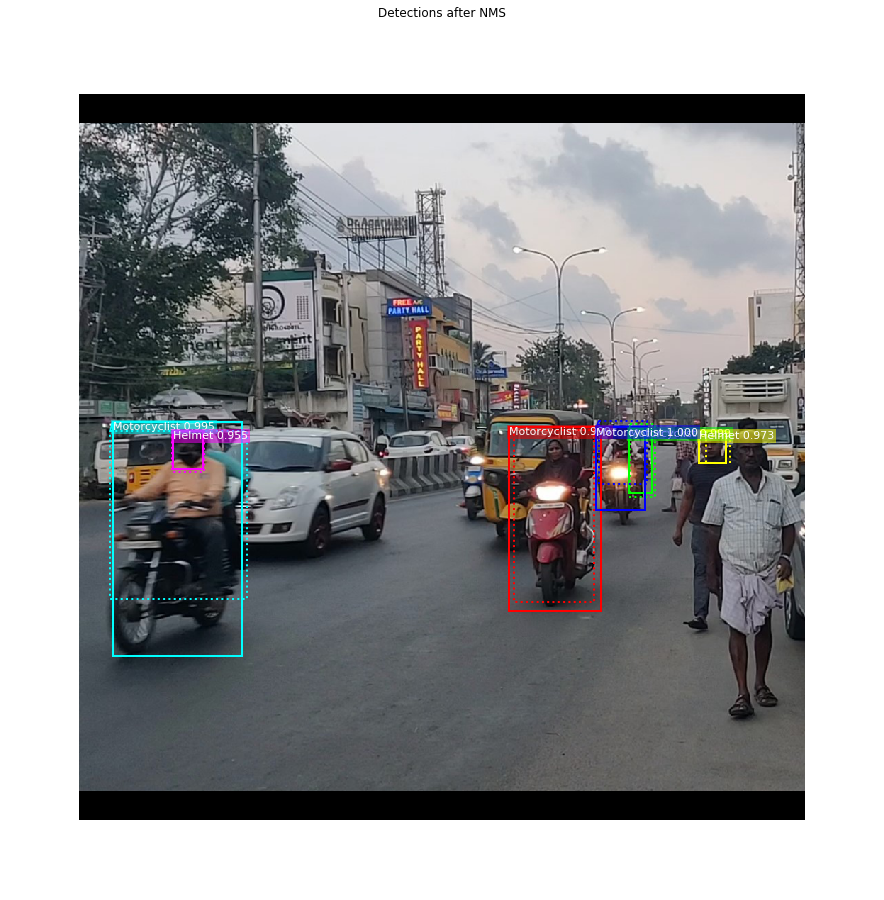

In [23]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

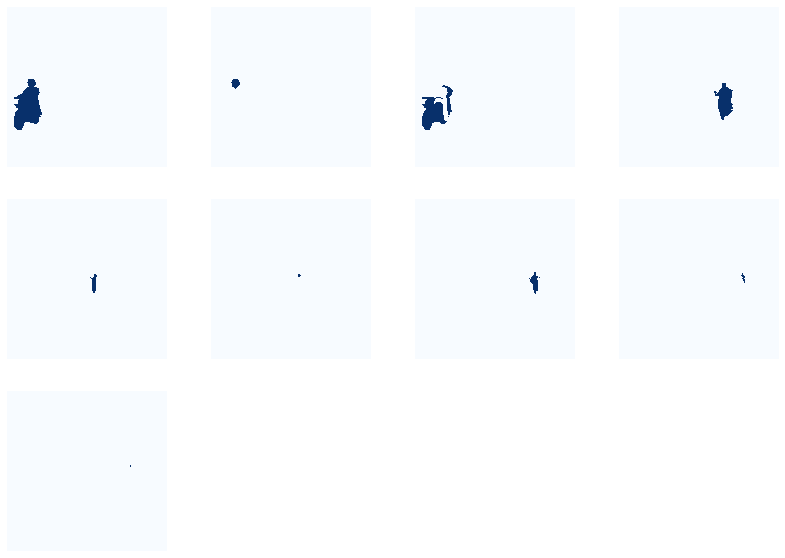

In [24]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [25]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
6 detections: ['Motorcyclist' 'Motorcyclist' 'Motorcyclist' 'Motorcyclist' 'Helmet'
 'Helmet']


In [26]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (6, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (6, 1024, 1024)       min:    0.00000  max:    1.00000  bool


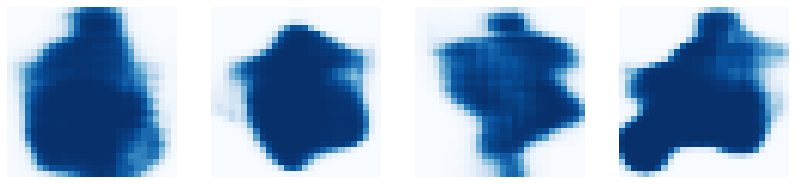

In [27]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

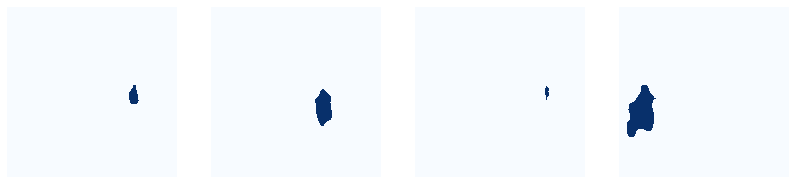

In [28]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [29]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   24.01555  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   32.55833  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   74.05051  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -8.66430  max:   92.28210  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


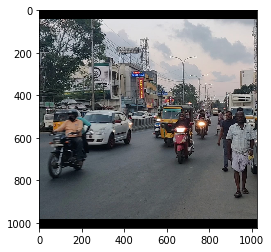

In [30]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

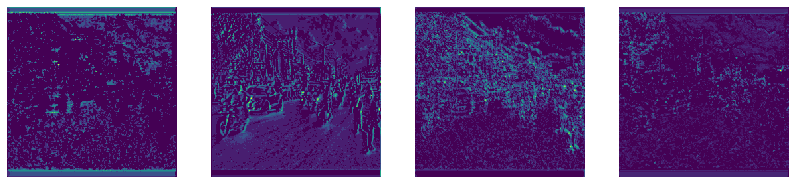

In [31]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)